## Анализ сайта «СберАвтоподписка»

#### Botasheva Zhanna

План работы

1. Провести подготовительную работу.
2. Провести разведочный анализ данных.
3. Научитесь предсказывать совершение целевого действия (ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователем целевого действия.
4. Упакуйте получившуюся модель в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие).

Описание атрибутов GA Sessions:
`Одна строка = один визит на сайт`
* session_id — ID визита;
* client_id — ID посетителя;
* visit_date — дата визита;
* visit_time — время визита;
* visit_number — порядковый номер визита клиента;
* utm_source — канал привлечения;
* utm_medium — тип привлечения;
* utm_campaign — рекламная кампания;
* utm_keyword — ключевое слово;
* device_category — тип устройства;
* device_os — ОС устройства;
* device_brand — марка устройства;
* device_model — модель устройства;
* device_screen_resolution — разрешение экрана;
* device_brand — марка устройства;
* device_model — модель устройства;
* device_browser — браузер;
* geo_country — страна;
* geo_city — город.

Описание атрибутов GA Hits:
`Одна строка = одно событие в рамках одного визита на сайт`
* session_id — ID визита;
* hit_date — дата события;
* hit_time — время события;
* hit_number — порядковый номер события в рамках сессии;
* hit_type — тип события;
* hit_referer — источник события;
* hit_page_path — страница события;
* event_category — тип действия;
* event_action — действие;
* event_label — тег действия;
* event_value — значение результата действия.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# from catboost import CatBoostClassifier
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
# from bayes_opt import BayesianOptimization

### 1. Загрузка и общий анализ датасетов

В данной части работы выполнены следующие шаги:

* Анализирован предоставленный датасет;
* Изучены описания всех представленных атрибутов;
* Произведена оценка полноты и качества данных, а также попытка понять их реальный контекст;
* Данные приведены к удобной и структурированной форме для дальнейшей обработки.

In [13]:
df_session = pd.read_csv('ga_sessions.csv')
df_hits = pd.read_csv('ga_hits.csv')

In [14]:
df_session.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [15]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [16]:
df_session.info()
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 1

In [17]:
# Временной период 'df_session' и 'df_ga_hits'
print(f"События 'df_session' в рамках одного визита с {df_session.visit_date.min()} по {df_session.visit_date.max()}.") 
print(f"События 'df_ga_hits' в рамках одного визита с {df_hits.hit_date.min()} по {df_hits.hit_date.max()}.")  

События 'df_session' в рамках одного визита с 2021-05-19 по 2021-12-31.
События 'df_ga_hits' в рамках одного визита с 2021-05-19 по 2021-12-31.


В файле ga_hits.csv содержатся данные о событиях, происходящих в рамках каждой сессии, взятых из другого датасета ga_sessions.csv.
Объем данных в df_session составляет 1 860 042 строк и 18 столбцов, в ga_hits.csv - 15 726 470 строк и 11 столбцов. Эти данные отражают события, произошедшие за один визит в период с 19 мая 2021 года по 31 декабря 2021 года. Датасет охватывает период с запуска сервиса "СберАвтоподписка" до конца 2021 года.

In [18]:
# Дубликаты
print(df_session.duplicated().sum())
print(df_hits.duplicated().sum())

0
0


In [19]:
# Прропуски
print('df_session')
print(df_session.isna().sum())
print('df_hits')
print( df_hits.isna().sum())

df_session
session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64
df_hits
session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64


В обоих датасетах отсутствуют дублирующиеся записи.
В df_session значительные пропуски в атрибутах, что может повлиять на анализ маркетинговых каналов и устройств.
В df_hits пропуски в временных метках и параметрах событий, что может ограничить анализ поведения пользователей и событий.
Рассмотрим стратегию обработки пропусков отдельно для каждого датасета и сделаем анализ.

### 2. Анализ датасета `df_session`

Поработаем с колонками, где есть пропуски:
* utm_source: 97 пропуска
* utm_campaign: 219 603 пропуска
* utm_adcontent: 335 615 пропусков
* utm_keyword: 1 082 061 пропуск
* device_os: 1 070 138 пропусков
* device_brand: 367 178 пропусков
* device_model: 1 843 704 пропуска

`utm_source` - канал привлечения

In [20]:
# Количество уникальных значений
nunique_utm_source = df_session.utm_source.nunique()
nunique_utm_campaign = df_session.utm_campaign.nunique()
nunique_utm_adcontent = df_session.utm_adcontent.nunique()
nunique_utm_keyword = df_session.utm_keyword.nunique()
nunique_device_os = df_session.device_os.nunique()
nunique_device_brand = df_session.device_brand.nunique()
nunique_device_model = df_session.device_model.nunique()

print('Количество уникальных значений в `utm_source`:', nunique_utm_source)
print('Количество уникальных значений в `utm_campaign`:', nunique_utm_campaign)
print('Количество уникальных значений в `utm_adcontent`:', nunique_utm_adcontent)
print('Количество уникальных значений в `utm_keyword`:', nunique_utm_keyword)
print('Количество уникальных значений в `device_os`:', nunique_device_os)
print('Количество уникальных значений в `device_brand`:', nunique_device_brand)
print('Количество уникальных значений в `device_model`:', nunique_device_model)

Количество уникальных значений в `utm_source`: 293
Количество уникальных значений в `utm_campaign`: 412
Количество уникальных значений в `utm_adcontent`: 286
Количество уникальных значений в `utm_keyword`: 1219
Количество уникальных значений в `device_os`: 13
Количество уникальных значений в `device_brand`: 205
Количество уникальных значений в `device_model`: 104


In [21]:
# первые 10 наиболее часто встречающихся значений
print(f'Первые 10 наиболее часто встречающихся значений {df_session.utm_source.value_counts(dropna=False).head(10)}')
print(f'Первые 10 наиболее часто встречающихся значений {df_session.utm_campaign.value_counts(dropna=False).head(10)}')
print(f'Первые 10 наиболее часто встречающихся значений {df_session.utm_adcontent.value_counts(dropna=False).head(10)}')
print(f'Первые 10 наиболее часто встречающихся значений {df_session.utm_keyword.value_counts(dropna=False).head(10)}')
print(f'Первые 10 наиболее часто встречающихся значений {df_session.device_os.value_counts(dropna=False).head(10)}')
print(f'Первые 10 наиболее часто встречающихся значений {df_session.device_brand.value_counts(dropna=False).head(10)}')
print(f'Первые 10 наиболее часто встречающихся значений {df_session.device_model.value_counts(dropna=False).head(10)}')

Первые 10 наиболее часто встречающихся значений utm_source
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
Name: count, dtype: int64
Первые 10 наиболее часто встречающихся значений utm_campaign
LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
TmThBvoCcwkCZZUWACYq     26597
XHNUiSKKGTEpSAlaVMFQ     24524
okTXSMadDkjvntEHzIjp     24511
SgIUDYUKnyWHVowUOqid     22841
sbJRYgVfvcnqKJNDDYIr     20188
Name: count, dtype: int64
Первые 10 наиболее часто встречающихся значений utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNun

Столбцы `utm_source`, `utm_campaign`, `utm_adcontent`, `utm_keyword`, `device_model` являются не очень информативными. Исключим их.

In [22]:
df_session = df_session.drop(['utm_source', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_model'], axis=1)

Преобразуем столбцы visit_date и visit_time, добавим новые признаки

In [23]:
# Преобразование visit_date и visit_time в тип datetime:
df_session['visit_datetime'] = pd.to_datetime(df_session['visit_date'] + ' ' + df_session['visit_time'])

In [24]:
# Создание дополнительных признаков 'day_of_week' b 'hour'
df_session['day_of_week'] = df_session['visit_datetime'].dt.day_name()
df_session['hour'] = df_session['visit_datetime'].dt.hour

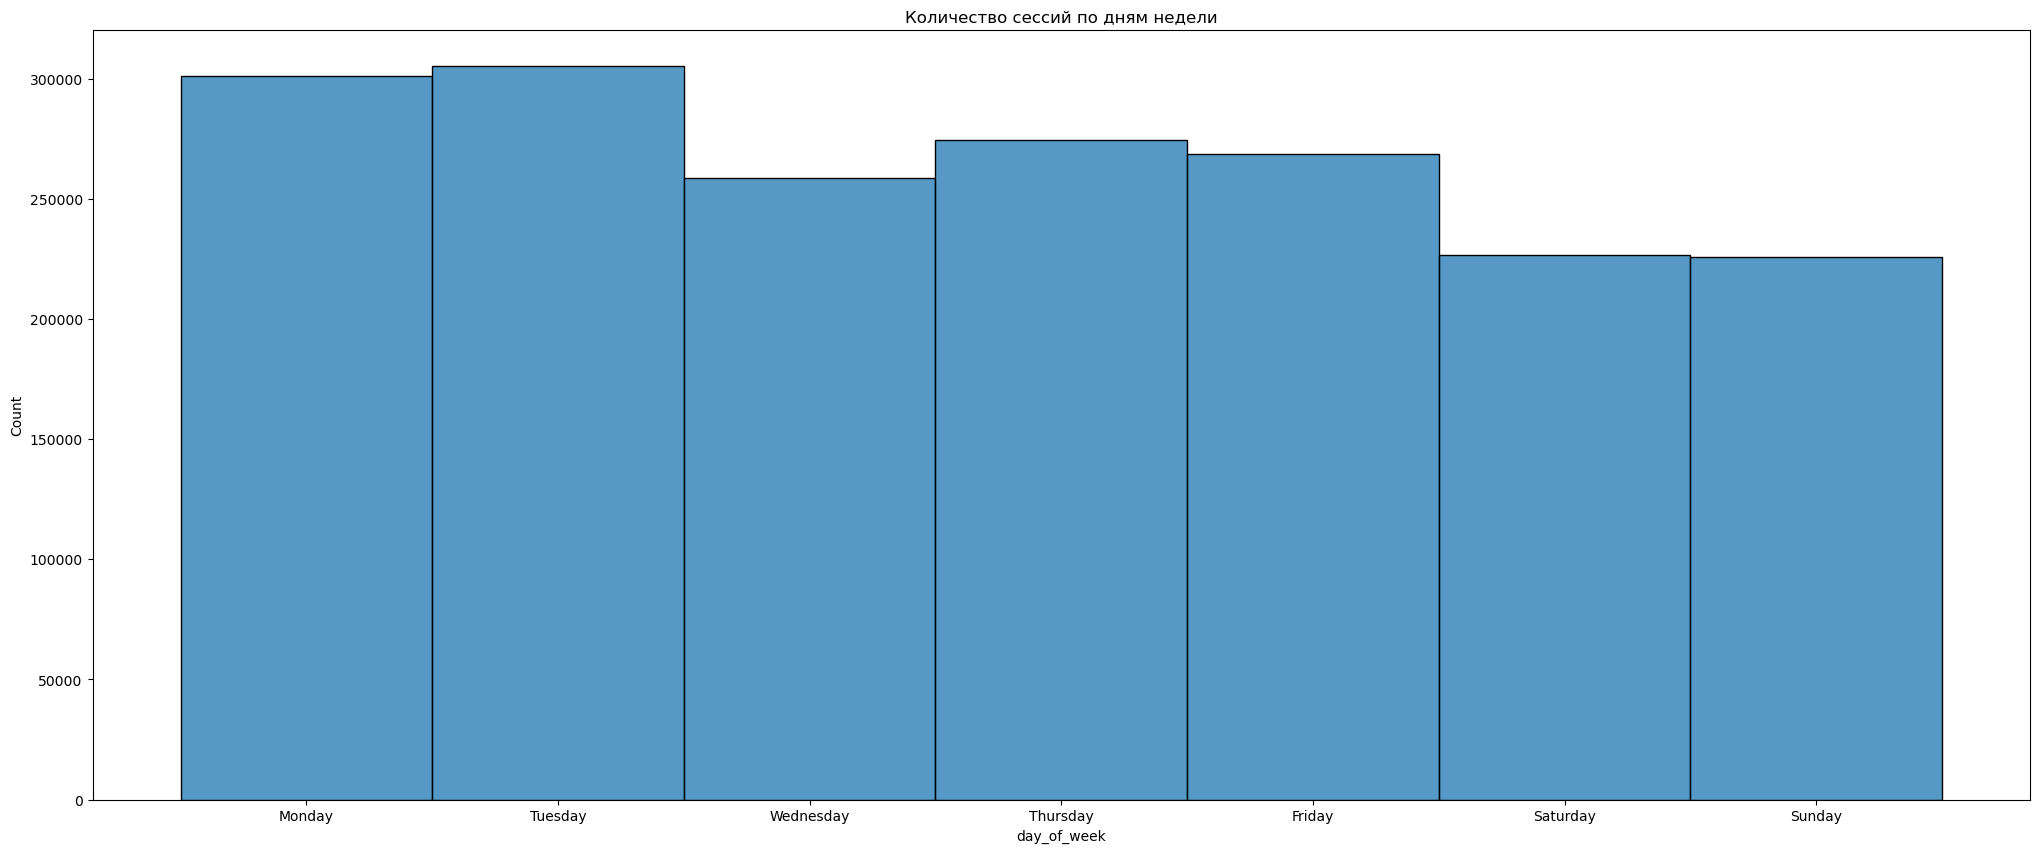

In [25]:
# Создаем список дней недели в нужном порядке
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Преобразуем колонку в категориальный тип с заданным порядком
df_session['day_of_week'] = pd.Categorical(df_session['day_of_week'], categories=days_order, ordered=True)

# Строим график
plt.figure(figsize=(25, 10))
sns.histplot(df_session, x='day_of_week', discrete=True)
plt.title('Количество сессий по дням недели')
plt.show();

Количество сессий по дням недели
* Наибольшее количество сессий приходится на понедельник и вторник, что может свидетельствовать о повышенной активности пользователей в начале рабочей недели.
* Среда и четверг показывают умеренный уровень активности, немного ниже, чем в начале недели.
* Пятница также демонстрирует заметное снижение количества сессий по сравнению с началом недели.
* Суббота и воскресенье — дни с наименьшей активностью, что характерно для снижения пользовательской активности в выходные дни.

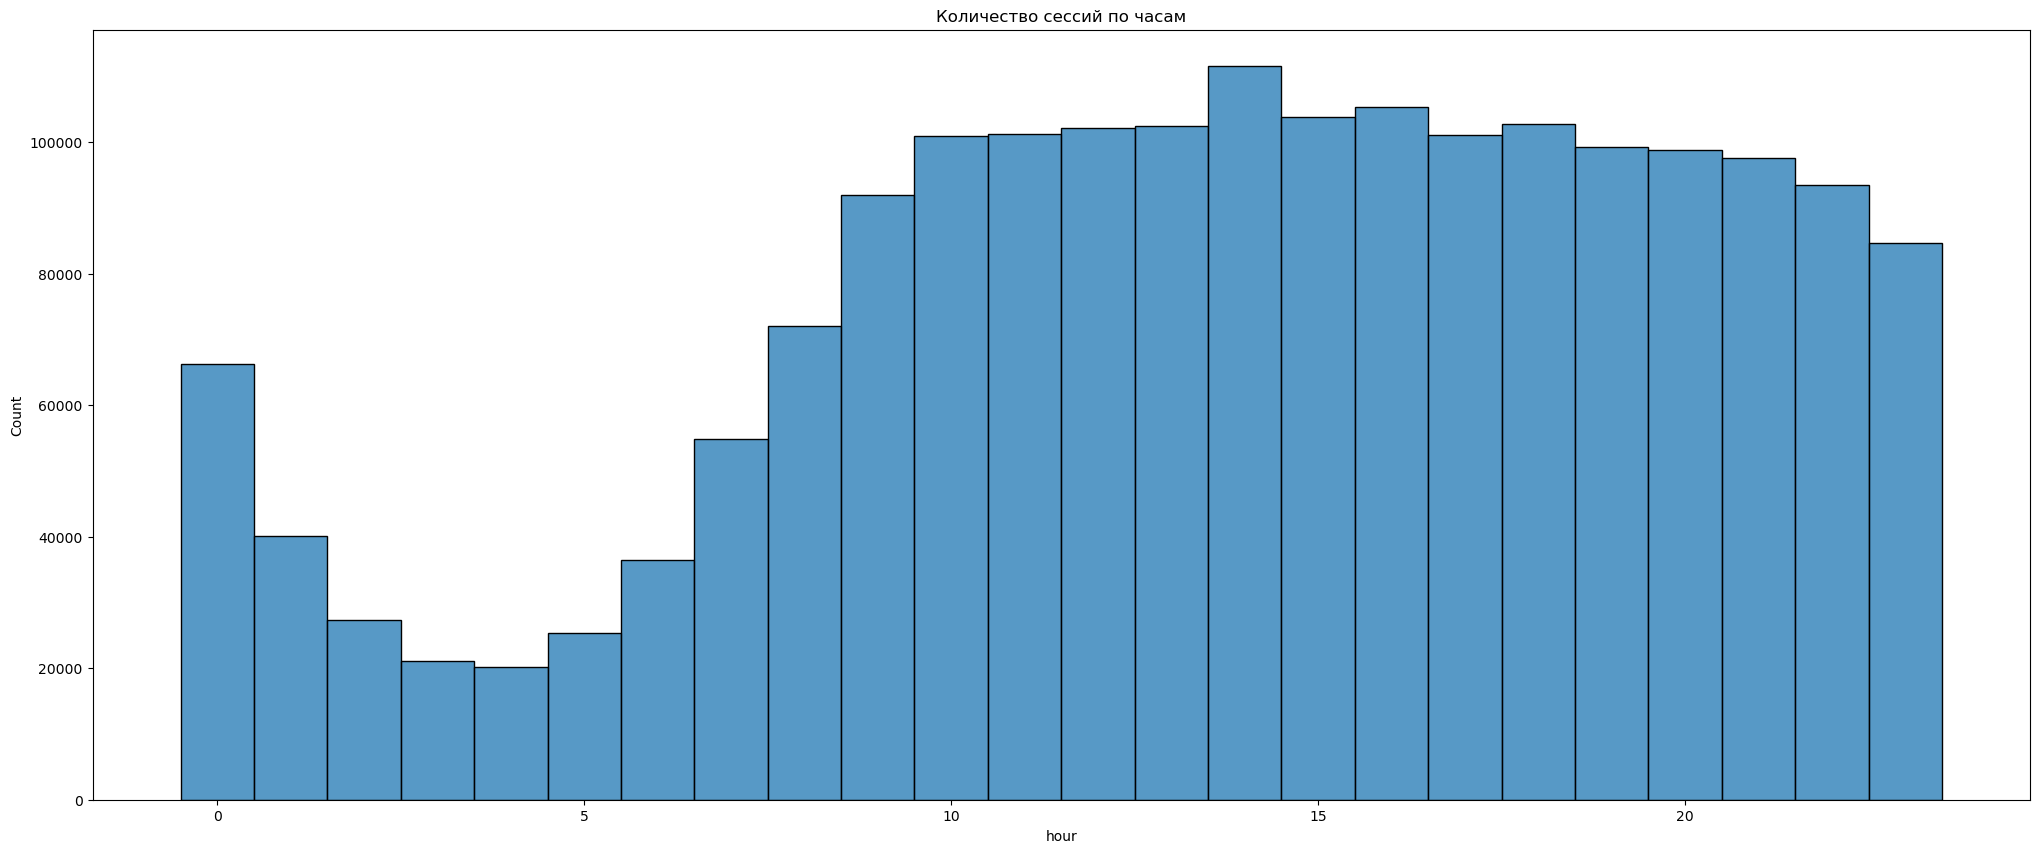

In [26]:
plt.figure(figsize=(25, 10))
sns.histplot(df_session, x='hour', discrete=True)
plt.title('Количество сессий по часам');

Количество сессий по часам
* Пик активности наблюдается примерно в диапазоне с 12 до 15 часов, что указывает на наибольшее количество сессий в обеденное время.
* Наименьшее количество сессий зафиксировано в ранние утренние часы, примерно с 0 до 4 часов, что логично, так как в это время активность пользователей минимальна.
* Распределение показывает, что активность пользователей постепенно увеличивается с утра, достигает максимума в середине дня и затем постепенно снижается к вечеру и ночи.

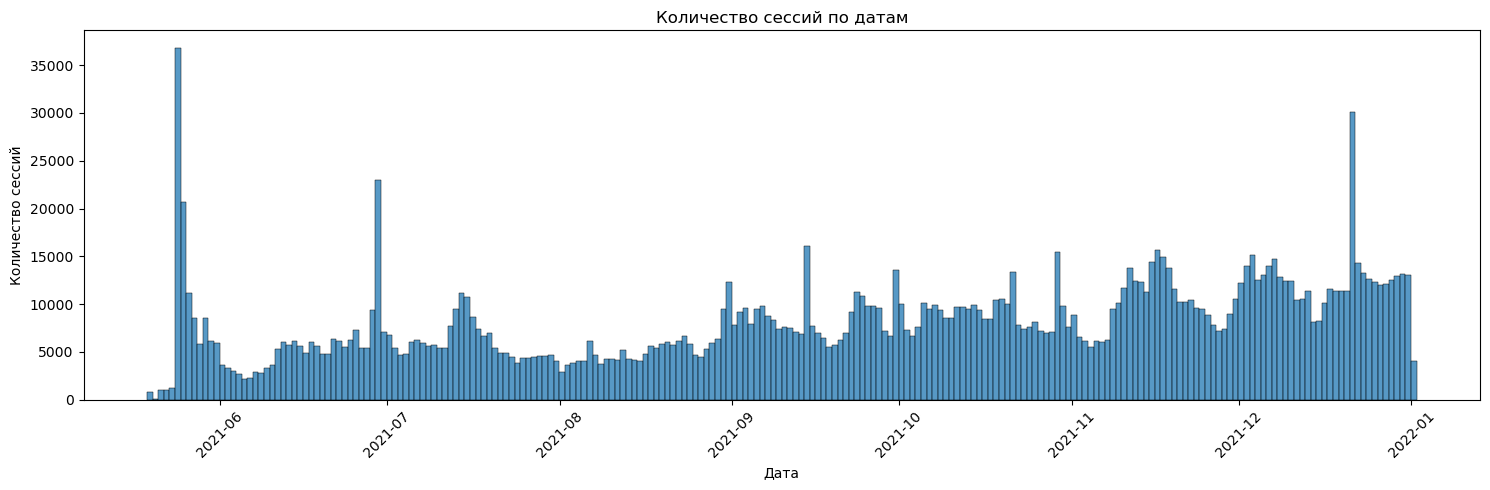

In [27]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 5))
sns.histplot(df_session, x='visit_datetime', discrete=True)

plt.title('Количество сессий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')

# Форматирование дат на оси X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Основные метки — по месяцам
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Формат отображения

plt.xticks(rotation=45)  # Поворот меток для читаемости
plt.tight_layout()
plt.show()

In [28]:
df_session['visit_time'] = df_session['visit_time'].astype('datetime64[ns]')
df_session['visit_time_hour'] = df_session['visit_time'].dt.hour + 1
df_session['visit_time_minute'] = df_session['visit_time'].dt.minute + 1

Количество сессий по датам

Основные пики:
* Первый пик: в начале периода (май 2021) — очень высокий уровень сессий, что может свидетельствовать о запуске сервиса, маркетинговых акциях или промо-кампаниях.
* Последующие пики: в июле, сентябре, ноябре и декабре 2021 года — также наблюдаются значительные всплески активности, что может быть связано с сезонными факторами, маркетинговыми активностями или внешними событиями

In [29]:
# Рассмотрим visit_number
visit_counts = df_session.visit_number.value_counts(dropna=False, ascending=False)
visit_counts.head(20)

visit_number
1     1376349
2      235656
3       81068
4       41666
5       24271
6       16473
7       11640
8        8735
9        6692
10       5413
11       4473
12       3702
13       3131
14       2672
15       2318
16       2020
17       1794
18       1606
19       1430
20       1296
Name: count, dtype: int64

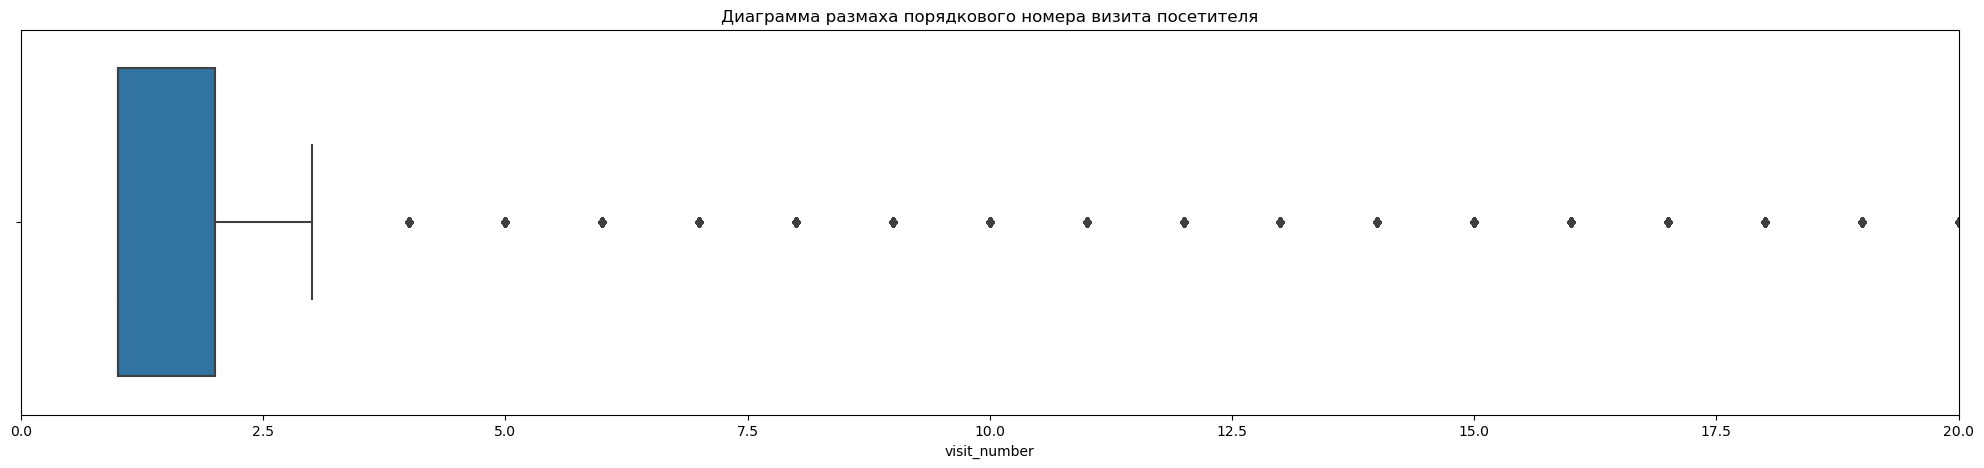

In [30]:
plt.figure(figsize=(25, 5))
sns.boxplot(data=df_session, x='visit_number')
plt.xlim(0, 20)
plt.title('Диаграмма размаха порядкового номера визита посетителя');

Большинство пользователей совершают 1-2 визита, что говорит о высокой "оттокающей" активности.
Возможно, стоит изучить причины, по которым пользователи не возвращаются после первых визитов.

In [31]:
# Уникальность utm_medium
df_session.utm_medium.nunique()

56

In [32]:
df_session.utm_medium.value_counts(dropna=False)

utm_medium
banner               552272
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               480
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
CPM                      40
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article  

In [33]:
# Заменим значения (not set) на (none)
df_session['utm_medium'] = df_session['utm_medium'].replace('(not set)','(none)')

Рассмотрим признаки `device_category`, `device_os`, `device_brand`

In [34]:
# Уникальность device_category, device_os, device_brand
print('Уникальность device_category:', df_session['device_category'].nunique())
print('Уникальность device_os:', df_session['device_os'].nunique())
print('Уникальность device_brand:', df_session['device_brand'].nunique())

Уникальность device_category: 3
Уникальность device_os: 13
Уникальность device_brand: 205


In [35]:
print(df_session['device_category'].value_counts(dropna=False))
print(df_session['device_os'].value_counts(dropna=False))
print(df_session['device_brand'].value_counts(dropna=False).head(20))

device_category
mobile     1474871
desktop     366863
tablet       18308
Name: count, dtype: int64
device_os
NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: count, dtype: int64
device_brand
Apple        551088
NaN          367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Meizu          3750
Lenovo         3148
Blackview      2759
Tecno          2654
LG             2447
Name: count, dtype: int64


In [36]:
df_session['device_brand'].unique()

array(['Huawei', 'Samsung', 'Xiaomi', 'Apple', 'Lenovo', nan, 'Vivo',
       'Meizu', 'OnePlus', '(not set)', 'BQ', 'Realme', 'OPPO', 'itel',
       'Philips', 'Nokia', 'Alcatel', 'LG', 'Tecno', 'Asus', 'Infinix',
       'Sony', 'ZTE', 'Wiko', 'Google', 'Micromax', 'Blackview',
       'Oukitel', 'Wileyfox', 'Motorola', 'HOMTOM', 'Cubot', 'DOOGEE',
       'China Phone', 'DEXP', 'Neffos', 'TP-Link', 'Hisense', 'Acer',
       'Vsmart', 'BlackBerry', 'Umidigi', 'Leagoo', 'Highscreen',
       'Ulefone', 'HTC', 'Symphony', 'LeEco', 'Prestigio', 'POCO',
       'Vestel', 'Guophone', 'Vertex', 'CAT', 'InFocus', 'TCL',
       'SonyEricsson', 'Inoi', 'Nomu', 'Sharp', 'Jiake', 'ZOJI', 'Yuntab',
       'Mozilla', 'Vernee', 'Tele2', 'H96', 'Kyocera', 'Karbonn', 'BLU',
       'Haier', 'Kingplay', 'Coolpad', 'MTC', 'LeTV', 'iNew', 'A1',
       'Gionee', 'General Mobile', 'Digma', 'Yota Devices', 'Gome',
       'Egreat', 'Kata', 'Mito', 'Poptel', 'Flylion', 'AGM', 'SenseIT',
       'Archos', 'Teclast',

In [37]:
# Заполнение пропусков в 'device_os' и 'device_brand' значением 'Unknown'
df_session['device_os'] = df_session['device_os'].fillna('Unknown')
df_session['device_brand'] = df_session['device_brand'].fillna('Unknown')
df_session['device_os'] = df_session['device_os'].replace('(not set)','Unknown')
df_session['device_brand'] = df_session['device_brand'].replace('(not set)','Unknown')

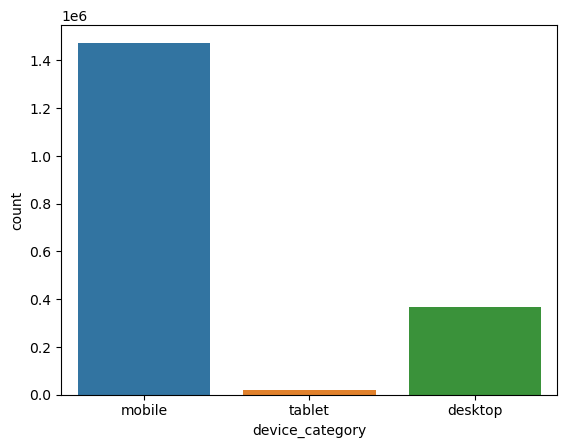

In [38]:
sns.countplot(data=df_session, x='device_category')
plt.show()

Признаки geo_country и geo_city

In [39]:
# Посмотрим уникальность признаков geo_country и geo_city
print(df_session['geo_country'].nunique())
print(df_session['geo_country'].value_counts(dropna=False).head(20))
print(df_session['geo_city'].nunique())
print(df_session['geo_city'].value_counts(dropna=False).head(20))

166
geo_country
Russia            1800565
United States       11784
Ukraine              9012
Ireland              4034
Belarus              3636
Sweden               2694
Kazakhstan           2279
Germany              2232
Turkey               1953
Netherlands          1549
Uzbekistan           1523
United Kingdom       1462
(not set)            1146
Kyrgyzstan            974
Georgia               935
France                790
Cyprus                765
Armenia               681
Finland               643
Spain                 599
Name: count, dtype: int64
2548
geo_city
Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Irkutsk            

Поскольку признаки `geo_city` и `geo_country` являются однотипными, в дальнейшем будем использовать только признак `geo_city`.

### 3. Анализ датасета df_hits¶

Целевое действие — события типа «Оставить заявку» и «Заказать звонок»

(df_hits.event_action in

['sub_car_claim_click',

'sub_car_claim_submit_click',

'sub_open_dialog_click',

'sub_custom_question_submit_click',

'sub_call_number_click',

'sub_callback_submit_click',

'sub_submit_success',

'sub_car_request_submit_click']).



Всего целевых действий = 104908 из 15726470 (0.67%)



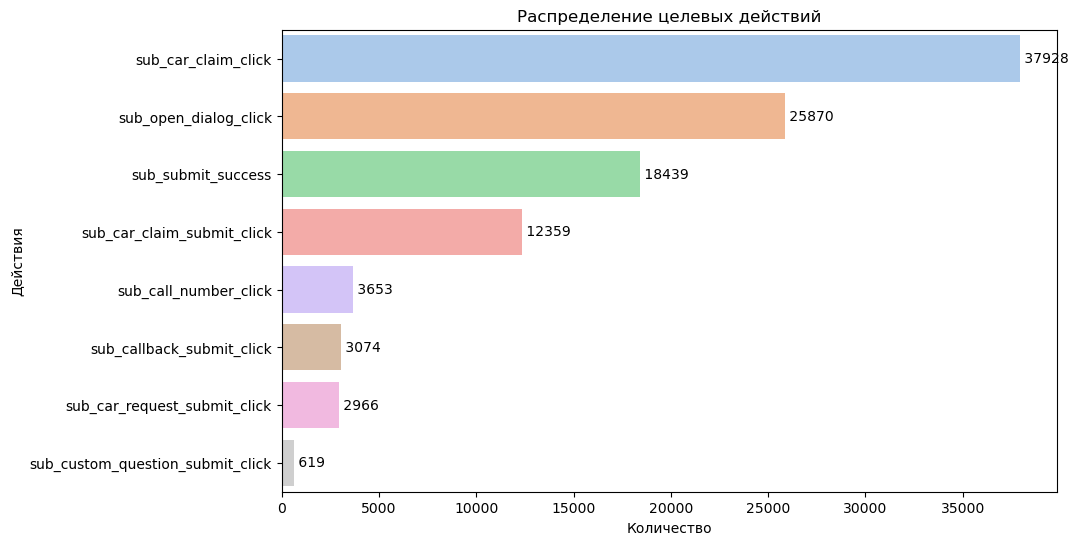

In [40]:
# список целевых событий
all_targets = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

# подсчёт общего количества действий
total_actions = len(df_hits)

# подсчёт количества каждого целевого действия
target_counts = df_hits[df_hits['event_action'].isin(all_targets)]['event_action'].value_counts()

# сортировка по количеству
sorted_targets = target_counts.items()
total_target_actions = target_counts.sum()

# вывод общего количества и доли целевых действий
print(f'Всего целевых действий = {total_target_actions} из {total_actions} ({total_target_actions / total_actions * 100:.2f}%)\n')

# сортировка по убыванию
sorted_targets = sorted(target_counts.items(), key=lambda x: x[1], reverse=True)

# подготовка данных для графика
labels, data = zip(*sorted_targets)

# построение горизонтального барчарта
plt.figure(figsize=(10, 6))
sns.barplot(x=list(data), y=list(labels), palette='pastel')
plt.xlabel('Количество')
plt.ylabel('Действия')
plt.title('Распределение целевых действий')
for index, value in enumerate(data):
    plt.text(value, index, f' {value}', va='center')
plt.show()

In [41]:
# Анализ по страницам (hit_page_path)

# Посчитаем просмотры каждой страницы
page_views = df_hits['hit_page_path'].value_counts()

# Посчитаем целевые действия по страницам
all_targets = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

df_targets = df_hits[df_hits['event_action'].isin(all_targets)]

# Посчитаем целевые действия по страницам
target_counts = df_targets['hit_page_path'].value_counts()

# Объединим данные в DataFrame для анализа
df_page_stats = pd.DataFrame({
    'views': page_views,
    'targets': target_counts
}).fillna(0)

# Рассчитаем конверсию по страницам
df_page_stats['conversion_rate'] = df_page_stats['targets'] / df_page_stats['views']

# Топ-10 страниц по просмотрам
print("Топ-10 страниц по просмотрам:")
print(df_page_stats['views'].head(10))

# Топ-10 страниц по целевым действиям
print("\nТоп-10 страниц по целевым действиям:")
print(df_page_stats['targets'].head(10))

# Страницы с высоким трафиком и низкой конверсией
print("\nСтраницы с высоким трафиком и низкой конверсией:")
low_conversion_pages = df_page_stats[df_page_stats['conversion_rate'] < 0.01].sort_values('views', ascending=False)
print(low_conversion_pages.head(10))

Топ-10 страниц по просмотрам:
hit_page_path
/                                                                                                                                    21264
/.env?name=abc                                                                                                                           9
/?_branch_match_id=923493313355119768                                                                                                    6
/?bodytypes=hatchback&transmissions=at&isnew=false&priceto=600 000                                                                       1
/?brand=112&rental_car=exclude_rental                                                                                                   11
/?brand=112=model=1227&datefrom=2021&colors=white&transmissions=at&isnew=true                                                            2
/?brand=112=model=1227&isnew=false&priceto=600 000&pricefrom=450 000&mileageto=120 000                                    

In [42]:
# Посчитаем количество уникальных session_id, в которых есть целевое событие
sessions_with_target_events = df_targets['session_id'].nunique()

# Рассчитаем конверсию по сессиям
total_sessions = df_hits['session_id'].nunique()
conversion_rate = sessions_with_target_events / total_sessions * 100

print(f"Общее число сессий: {total_sessions}")
print(f"Сессий с целевыми событиями: {sessions_with_target_events}")
print(f"Конверсия по сессиям: {conversion_rate:.2f}%")

Общее число сессий: 1734610
Сессий с целевыми событиями: 50760
Конверсия по сессиям: 2.93%


In [43]:
numeric_cols = df_hits.select_dtypes(include='number')
corr_matrix = numeric_cols.corr()
print(corr_matrix)

             hit_time  hit_number  event_value
hit_time     1.000000    0.605906          NaN
hit_number   0.605906    1.000000          NaN
event_value       NaN         NaN          NaN


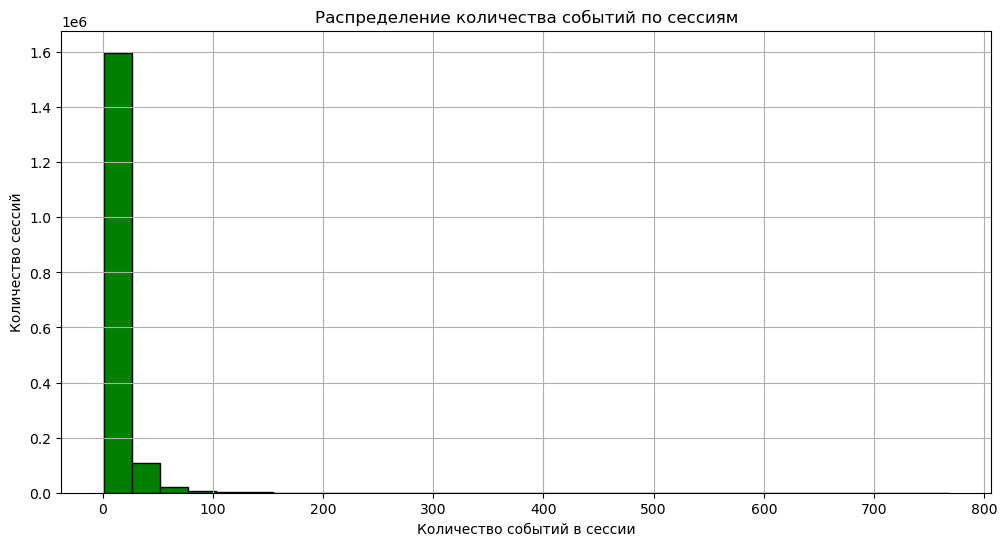

In [44]:
# Количество событий в каждой сессии:
session_counts = df_hits['session_id'].value_counts()

# Построим гистограмму частот
plt.figure(figsize=(12, 6))
plt.hist(session_counts, bins=30, color='green', edgecolor='black')
plt.title('Распределение количества событий по сессиям')
plt.xlabel('Количество событий в сессии')
plt.ylabel('Количество сессий')
plt.grid(True)
plt.show()

Добавим новый столбец `target`в `df_session`, в который запишем наличие целевых событий из столбца `event_action`. Если в рамках сессии зафиксировано хотя бы одно из целевых событий, значение `target` будет равно 1, иначе — 0. Для сессий, для которых в df_hits не найдено ни одного события, целевая переменная также будет установлена в 0.

In [45]:
# Список целевых событий
target_events = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

# Получим уникальные session_id, в которых есть целевые события
target_sessions = df_hits[df_hits['event_action'].isin(target_events)]['session_id'].unique()

# Создаем столбец target в df_session
# Изначально заполняем нулями
df_session['target'] = 0

# Обновляем target для тех сессий, где есть целевое событие
df_session.loc[df_session['session_id'].isin(target_sessions), 'target'] = 1

# Теперь в df_session есть столбец target
# В нем 1 — если в сессии было хотя бы одно целевое событие, 0 — если не было

In [46]:
distribution = df_session["target"].value_counts(dropna=False, normalize=True)
print('Распределение целевой переменной:')
print(distribution.apply(lambda x: f"{x:.2%}"))

Распределение целевой переменной:
target
0    97.30%
1     2.70%
Name: proportion, dtype: object


Обратите внимание, что только 2.7% всех сессий завершились выполнением хотя бы одного целевого действия.

Посмотрим признак `device_screen_resolution`

In [47]:
# Подсчет количества уникальных значений в столбце 'device_screen_resolution', включая пропущенные значения (NaN).
df_session['device_screen_resolution'].value_counts(dropna=False)

device_screen_resolution
414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
              ...  
2262x1553         1
1097x617          1
421x847           1
1791x1007         1
464x1123          1
Name: count, Length: 5039, dtype: int64

Добавим новые признаки `device_screen_resolution_width`, `device_screen_resolution_height`, `device_screen_resolution_ratio`

In [48]:
def parse_resolution(resolution):
    # Проверяем, что входное значение является строкой и содержит символ 'x', разделяющий ширину и высоту
    if isinstance(resolution, str) and 'x' in resolution:
        try:
            # Разделяем строку по символу 'x' на две части: ширину и высоту
            width, height = resolution.split('x')
            # Преобразуем ширину и высоту в числа с плавающей точкой и возвращаем их
            return float(width), float(height)
        except ValueError:
            # В случае ошибки преобразования (например, неправильный формат), возвращаем значения по умолчанию (1, 1)
            return 1, 1
    else:
        # Если входное значение не строка или не содержит 'x', возвращаем значения по умолчанию (1, 1)
        return 1, 1

# Применяем функцию к каждому значению
df_session[['device_screen_resolution_width', 'device_screen_resolution_height']] = df_session['device_screen_resolution'].apply(parse_resolution).apply(pd.Series)

# Вычисляем соотношение
df_session['device_screen_resolution_ratio'] = df_session['device_screen_resolution_width'] / df_session['device_screen_resolution_height']

Добавим признак `city_importance`

In [49]:
def get_top_cities_dict(df, target_value=1, top_n=100):
    """
    Возвращает словарь с городами и количеством посещений для целевой переменной target == target_value.
    
    Parameters:
    - df: DataFrame, содержащий данные.
    - target_value: значение целевой переменной, по которому фильтруем (по умолчанию 1).
    - top_n: число топовых городов, по умолчанию 100.
    
    Returns:
    - dict: ключи — города, значения — количество посещений.
    """
    # Фильтруем DataFrame по целевой переменной, равной target_value
    # Затем считаем количество посещений для каждого города, включая пропущенные значения (dropna=False)
    # После этого берем только топ_n городов с наибольшим количеством посещений
    top_cities_series = df[df['target'] == target_value]['geo_city'].value_counts(dropna=False).head(top_n)
    # Преобразуем полученную серию в словарь, где ключи — города, значения — количество посещений
    return top_cities_series.to_dict()


city_visits_dict = get_top_cities_dict(df_session, target_value=1, top_n=100)

In [50]:
def get_city_importance(city):
    # Получаем количество посещений для данного города из словаря city_visits_dict
    # Если города нет в словаре, возвращается 0
    count = city_visits_dict.get(city, 0)
    
    # Определяем уровень важности города на основе количества посещений
    if count > 2000:
        return 'high'   # Высокая важность для городов с более чем 2000 посещений
    elif count >= 200:
        return 'medium' # Средняя важность для городов с 200 до 2000 посещений
    else:
        return 'low'    # Низкая важность для городов с менее чем 200 посещений

# Создаем новый признак 'city_importance' в DataFrame, применяя функцию к каждому значению в столбце 'geo_city'
df_session['city_importance'] = df_session['geo_city'].apply(get_city_importance)

In [51]:
df_session

,session_id,client_id,visit_date,visit_time,visit_number,utm_medium,device_category,device_os,device_brand,device_screen_resolution,...,visit_datetime,day_of_week,hour,visit_time_hour,visit_time_minute,target,device_screen_resolution_width,device_screen_resolution_height,device_screen_resolution_ratio,city_importance
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,2025-06-09 14:36:32,1,banner,mobile,Android,Huawei,360x720,...,2021-11-24 14:36:32,Wednesday,14,15,37,0,360.0,720.0,0.500000,low
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,2025-06-09 08:21:30,1,cpm,mobile,Android,Samsung,385x854,...,2021-11-14 08:21:30,Sunday,8,9,22,0,385.0,854.0,0.450820,high
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,2025-06-09 02:42:06,1,banner,mobile,Android,Huawei,360x720,...,2021-12-28 02:42:06,Tuesday,2,3,43,0,360.0,720.0,0.500000,medium
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,2025-06-09 05:00:00,1,cpc,mobile,Unknown,Xiaomi,393x786,...,2021-05-29 05:00:00,Saturday,5,6,1,0,393.0,786.0,0.500000,high
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,2025-06-09 05:00:00,2,cpc,mobile,Unknown,Xiaomi,393x786,...,2021-05-29 05:00:00,Saturday,5,6,1,0,393.0,786.0,0.500000,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,2025-06-09 10:48:25,1,cpc,desktop,Windows,Unknown,1920x1080,...,2021-12-22 10:48:25,Wednesday,10,11,49,0,1920.0,1080.0,1.777778,high
1860038,9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,2025-06-09 08:00:00,1,(none),mobile,Unknown,Apple,390x844,...,2021-05-26 08:00:00,Wednesday,8,9,1,0,390.0,844.0,0.462085,low
1860039,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,2025-06-09 15:31:55,1,(none),mobile,iOS,Apple,375x667,...,2021-11-15 15:31:55,Monday,15,16,32,0,375.0,667.0,0.562219,high
1860040,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,2025-06-09 15:36:44,1,banner,mobile,Android,Xiaomi,393x851,...,2021-11-29 15:36:44,Monday,15,16,37,0,393.0,851.0,0.461810,medium


In [52]:
# Отбираем все строки DataFrame df_session, в которых есть хотя бы одно пропущенное значение (NaN)
rows_with_nan = df_session[df_session.isna().any(axis=1)]

In [53]:
rows_with_nan

,session_id,client_id,visit_date,visit_time,visit_number,utm_medium,device_category,device_os,device_brand,device_screen_resolution,...,visit_datetime,day_of_week,hour,visit_time_hour,visit_time_minute,target,device_screen_resolution_width,device_screen_resolution_height,device_screen_resolution_ratio,city_importance
44288,950433344634896286.1638285216.1638285216,221290007.163828,2021-11-30,2025-06-09 18:13:36,1,cpc,desktop,Windows,Unknown,0x0,...,2021-11-30 18:13:36,Tuesday,18,19,14,0,0.0,0.0,NaN,high
63108,1034855208904127115.1622241934.1622241934,240946004.162224,2021-05-29,2025-06-09 01:00:00,1,cpc,desktop,Unknown,Unknown,0x0,...,2021-05-29 01:00:00,Saturday,1,2,1,0,0.0,0.0,NaN,high
116630,1275445726215482012.1633495707.1633495707,296962849.1633495708,2021-10-06,2025-06-09 07:00:00,1,cpc,mobile,Unknown,Huawei,0x0,...,2021-10-06 07:00:00,Wednesday,7,8,1,0,0.0,0.0,NaN,medium
150895,1429325999168992177.1622324145.1622324145,332790892.162232,2021-05-30,2025-06-09 00:00:00,1,cpc,desktop,Unknown,Unknown,0x0,...,2021-05-30 00:00:00,Sunday,0,1,1,0,0.0,0.0,NaN,high
268575,1959491500856234812.1626264380.1626264380,456229667.1626264380,2021-07-14,2025-06-09 15:00:00,1,(none),desktop,Unknown,Unknown,0x0,...,2021-07-14 15:00:00,Wednesday,15,16,1,0,0.0,0.0,NaN,high
466768,2840248306670648388.1627536509.1627536509,661296841.1627536452,2021-07-29,2025-06-09 08:00:00,1,cpm,mobile,Unknown,Samsung,0x0,...,2021-07-29 08:00:00,Thursday,8,9,1,0,0.0,0.0,NaN,high
808806,4369400154622279642.1640775642.1640775642,1017330250.164078,2021-12-29,2025-06-09 14:00:42,1,organic,desktop,Linux,Unknown,0x0,...,2021-12-29 14:00:42,Wednesday,14,15,1,0,0.0,0.0,NaN,high
985350,5153955401013310840.1637528954.1637528954,1199998753.163753,2021-11-22,2025-06-09 00:09:14,1,cpc,desktop,Windows,Unknown,0x0,...,2021-11-22 00:09:14,Monday,0,1,10,0,0.0,0.0,NaN,high
1553066,7684970892572382028.1627280225.1627280225,1789296719.162728,2021-07-26,2025-06-09 09:00:00,1,cpm,mobile,Unknown,Samsung,0x0,...,2021-07-26 09:00:00,Monday,9,10,1,0,0.0,0.0,NaN,high
1598805,7890126052774737523.1622242931.1622242931,1837063127.1622242931,2021-05-29,2025-06-09 02:00:00,1,cpc,desktop,Unknown,Unknown,0x0,...,2021-05-29 02:00:00,Saturday,2,3,1,0,0.0,0.0,NaN,low


In [54]:
# Исключим пропуски
df_session.dropna(inplace=True)

In [59]:
df_session['visit_date'] = pd.to_datetime(df_session['visit_date'])
df_session['day_of_week'] = df_session['visit_date'].dt.dayofweek

In [60]:
df_session['day_of_week']

0          2
1          6
2          1
3          5
4          5
          ..
1860037    2
1860038    2
1860039    0
1860040    0
1860041    4
Name: day_of_week, Length: 1860031, dtype: int32

In [ ]:
# Сохранение 
df_session.to_csv('df_final.csv', index=False)

In [56]:
df = df_session.copy()

In [46]:
df.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_medium', 'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city',
       'visit_datetime', 'day_of_week', 'hour', 'visit_time_hour',
       'visit_time_minute', 'target', 'device_screen_resolution_width',
       'device_screen_resolution_height', 'device_screen_resolution_ratio',
       'city_importance'],
      dtype='object')

In [65]:
df= pd.read_csv('df_final.csv')
df

,session_id,client_id,visit_date,visit_time,visit_number,utm_medium,device_category,device_os,device_brand,device_screen_resolution,...,visit_datetime,day_of_week,hour,visit_time_hour,visit_time_minute,target,device_screen_resolution_width,device_screen_resolution_height,device_screen_resolution_ratio,city_importance
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,2025-06-09 14:36:32,1,banner,mobile,Android,Huawei,360x720,...,2021-11-24 14:36:32,2,14,15,37,0,360.0,720.0,0.500000,low
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,2025-06-09 08:21:30,1,cpm,mobile,Android,Samsung,385x854,...,2021-11-14 08:21:30,6,8,9,22,0,385.0,854.0,0.450820,high
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,2025-06-09 02:42:06,1,banner,mobile,Android,Huawei,360x720,...,2021-12-28 02:42:06,1,2,3,43,0,360.0,720.0,0.500000,medium
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,2025-06-09 05:00:00,1,cpc,mobile,Unknown,Xiaomi,393x786,...,2021-05-29 05:00:00,5,5,6,1,0,393.0,786.0,0.500000,high
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,2025-06-09 05:00:00,2,cpc,mobile,Unknown,Xiaomi,393x786,...,2021-05-29 05:00:00,5,5,6,1,0,393.0,786.0,0.500000,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860026,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,2025-06-09 10:48:25,1,cpc,desktop,Windows,Unknown,1920x1080,...,2021-12-22 10:48:25,2,10,11,49,0,1920.0,1080.0,1.777778,high
1860027,9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,2025-06-09 08:00:00,1,(none),mobile,Unknown,Apple,390x844,...,2021-05-26 08:00:00,2,8,9,1,0,390.0,844.0,0.462085,low
1860028,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,2025-06-09 15:31:55,1,(none),mobile,iOS,Apple,375x667,...,2021-11-15 15:31:55,0,15,16,32,0,375.0,667.0,0.562219,high
1860029,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,2025-06-09 15:36:44,1,banner,mobile,Android,Xiaomi,393x851,...,2021-11-29 15:36:44,0,15,16,37,0,393.0,851.0,0.461810,medium


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860031 entries, 0 to 1860030
Data columns (total 23 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   session_id                       object 
 1   client_id                        object 
 2   visit_date                       object 
 3   visit_time                       object 
 4   visit_number                     int64  
 5   utm_medium                       object 
 6   device_category                  object 
 7   device_os                        object 
 8   device_brand                     object 
 9   device_screen_resolution         object 
 10  device_browser                   object 
 11  geo_country                      object 
 12  geo_city                         object 
 13  visit_datetime                   object 
 14  day_of_week                      int64  
 15  hour                             int64  
 16  visit_time_hour                  int64  
 17  visit_ti

### 4. Подготовка и обработка данных

In [3]:
# Выбираем признаки для модели и целевую переменную
X = df[['visit_date','utm_medium', 'device_category', 'device_os', 'device_browser', 'geo_city',
        'city_importance','day_of_week','visit_number','visit_time_hour', 'visit_time_minute', 
        'device_screen_resolution_width', 'device_screen_resolution_height', 'device_screen_resolution_ratio']]
y = df['target']

# Обработка признака 'visit_date': преобразуем в тип datetime
X['visit_date'] = pd.to_datetime(X['visit_date'])

# Извлекаем из 'visit_date' дополнительные признаки
X['day_of_week'] = X['visit_date'].dt.dayofweek  # день недели (0-6)
X['visit_time_hour'] = X['visit_date'].dt.hour   # час визита
X['visit_time_minute'] = X['visit_date'].dt.minute # минута визита

# Удаляем исходный признак 'visit_date', так как он больше не нужен
X.drop('visit_date', axis=1, inplace=True)

# Преобразуем категориальные признаки в тип 'category' для оптимизации
categorical_features = ['utm_medium', 'device_category', 'device_os', 'device_browser', 'geo_city',
                        'city_importance', 'day_of_week']
for col in categorical_features:
    X[col] = X[col].astype('category')

# Определяем числовые признаки для дальнейшей обработки
numeric_features = ['visit_number', 'visit_time_hour', 'visit_time_minute',
                    'device_screen_resolution_width', 'device_screen_resolution_height', 
                    'device_screen_resolution_ratio']

# Создаем предобработчик, который выполнит кодирование категориальных признаков и масштабирование числовых
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # OneHotEncoder для категориальных
        ('num', StandardScaler(), numeric_features)  # Стандартизация числовых признаков
    ])

# Разделяем данные на обучающую и тестовую выборки (80% тренировка, 20% тест)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Далее делим обучающую выборку на тренировочную и валидационную (60% тренировка, 20% валидация)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)
# Итог: 60% данных для обучения, 20% для валидации, 20% для тестирования

### 5. Моделирование

Обучим несколько моделей, оценим на валидационной выборке и выберем лучшую, которую уже будем оптимизировать.

In [4]:
# Функция для создания конвейера (pipeline), объединяющего предобработку и модель
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),  # Предобработка данных (кодирование, масштабирование)
        ('classifier', model)           # Обучение модели
    ])

# Определение набора моделей для сравнения
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42),  # Логистическая регрессия
    'LightGBM': lgb.LGBMClassifier(objective='binary', class_weight='balanced', verbose=-1),  # LightGBM
    'CatBoost': CatBoostClassifier(verbose=False),  # CatBoost
}

scores = {}  # Словарь для хранения результатов ROC-AUC по моделям

# Обучение и оценка каждой модели
for name, model in models.items():
    pipeline = create_pipeline(model)  # Создаем конвейер с предобработкой и моделью
    pipeline.fit(X_train, y_train)     # Обучение модели на тренировочных данных
    pred_proba = pipeline.predict_proba(X_val)[:, 1]  # Предсказание вероятностей для валидационной выборки
    roc_auc = roc_auc_score(y_val, pred_proba)      # Вычисление ROC-AUC для оценки качества
    scores[name] = roc_auc  # Сохраняем результат в словарь
    print(f'{name} ROC-AUC: {roc_auc:.4f}')  # Выводим результат для каждой модели

LogisticRegression ROC-AUC: 0.6420
LightGBM ROC-AUC: 0.6810
CatBoost ROC-AUC: 0.6807


### 6.Bayesian Optimization

Поскольку задача сложная и требует значительных временных затрат на подбор гиперпараметров, будем использовать Bayesian Optimization для ускорения процесса.

In [6]:
# Функция для оценки качества модели LightGBM с гиперпараметрами, использующая кросс-валидацию
def lgb_cv_score(learning_rate, num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, max_depth):
    # Формируем словарь параметров модели с учетом границ и преобразований
    params = {
        'objective': 'binary',  # Бинарная классификация
        'metric': 'auc',        # Метрика ROC-AUC
        'verbose': -1,          # Отключение вывода логов
        'learning_rate': max(min(learning_rate, 1), 0),  # Ограничение learning_rate между 0 и 1
        'num_leaves': int(round(num_leaves)),             # Количество листьев, округляем до целого
        'min_data_in_leaf': int(round(min_data_in_leaf)), # Минимальное число данных в листе
        'feature_fraction': max(min(feature_fraction, 1), 0),  # Доля признаков для обучения
        'bagging_fraction': max(min(bagging_fraction, 1), 0),  # Доля данных для бэггинга
        'max_depth': int(round(max_depth)),               # Максимальная глубина дерева
        'class_weight': 'balanced'                        # Взвешивание классов для балансировки
    }
    # Создаем модель с текущими гиперпараметрами
    model = lgb.LGBMClassifier(**params)
    # Выполняем кросс-валидацию и возвращаем среднее значение ROC-AUC
    return cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()

# Определение границ гиперпараметров для оптимизации
bounds = {
    'learning_rate': (0.01, 0.3),
    'num_leaves': (20, 150),
    'min_data_in_leaf': (20, 100),
    'feature_fraction': (0.6, 1.0),
    'bagging_fraction': (0.6, 1.0),
    'max_depth': (3, 15)
}

# Инициализация байесовской оптимизации с функцией оценки и границами гиперпараметров
optimizer = BayesianOptimization(f=lgb_cv_score, pbounds=bounds, random_state=42)

# Запуск процесса поиска лучших гиперпараметров с начальным набором точек и итерациями
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
| 1         | 0.6636    | 0.7498    | 0.9803    | 0.2223    | 10.18     | 32.48     | 40.28     |
| 2         | 0.6534    | 0.6232    | 0.9465    | 0.1843    | 11.5      | 21.65     | 146.1     |
| 3         | 0.6715    | 0.933     | 0.6849    | 0.06273   | 5.201     | 44.34     | 88.22     |
| 4         | 0.6701    | 0.7728    | 0.7165    | 0.1874    | 4.674     | 43.37     | 67.63     |
| 5         | 0.6718    | 0.7824    | 0.9141    | 0.06791   | 9.171     | 67.39     | 26.04     |
| 6         | 0.673     | 0.843     | 0.6682    | 0.02886   | 14.39     | 97.25     | 125.1     |
| 7         | 0.6641    | 0.7218    | 0.6391    | 0.2084    | 8.282     | 29.76     | 84.37     |
| 8         | 0.6675    | 0.6138    | 0.9637    | 0.08505   | 10.95     | 44.94     | 87.61     |
| 9         | 0.6498

In [7]:
# Получаем лучшие гиперпараметры, найденные в процессе байесовской оптимизации
best_params = optimizer.max['params']

# Округляем параметры, которые должны быть целыми числами
best_params['num_leaves'] = int(round(best_params['num_leaves']))
best_params['min_data_in_leaf'] = int(round(best_params['min_data_in_leaf']))
best_params['max_depth'] = int(round(best_params['max_depth']))

# Ограничиваем значения гиперпараметров в диапазоне [0, 1]
best_params['learning_rate'] = max(min(best_params['learning_rate'], 1), 0)
best_params['feature_fraction'] = max(min(best_params['feature_fraction'], 1), 0)
best_params['bagging_fraction'] = max(min(best_params['bagging_fraction'], 1), 0)

# Создаем финальную модель с оптимальными гиперпараметрами внутри конвейера
final_model = create_pipeline(lgb.LGBMClassifier(**best_params))

# Обучаем финальную модель на всей тренировочной выборке
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['utm_medium',
                                                   'device_category',
                                                   'device_os',
                                                   'device_browser', 'geo_city',
                                                   'city_importance',
                                                   'day_of_week']),
                                                 ('num', StandardScaler(),
                                                  ['visit_number',
                                                   'visit_time_hour',
                                                   'visit_time_minute',
                                                   'device_screen_resolution_width',
                                                   'device_screen_resolution_height',
                                                   'device_screen_resolution_ratio'])])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.8430179407605753,
                                feature_fraction=0.6682096494749166,
                                learning_rate=0.02886496196573106, max_depth=14,
                                min_data_in_leaf=97, num_leaves=125))])

In [8]:
best_params

{'bagging_fraction': 0.8430179407605753,
 'feature_fraction': 0.6682096494749166,
 'learning_rate': 0.02886496196573106,
 'max_depth': 14,
 'min_data_in_leaf': 97,
 'num_leaves': 125}

In [9]:
# Оценка на тестовой выборке (по желанию)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
print('Test ROC-AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC-AUC: 0.6872083776110979


Нарисуем roc-кривую для наилучшей модели.

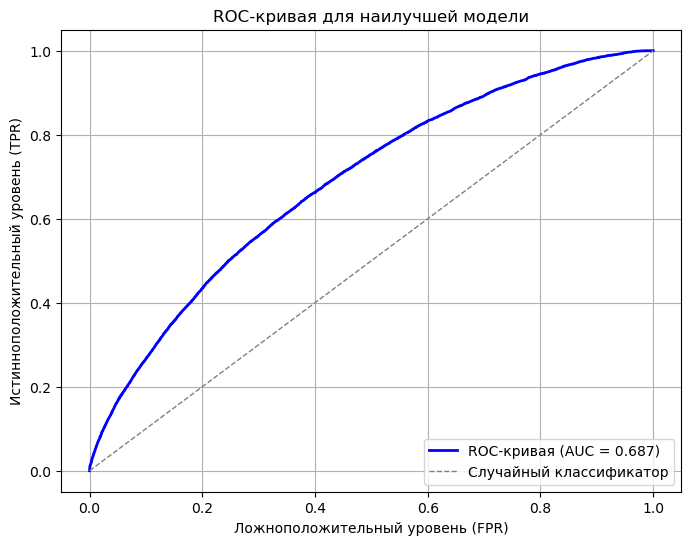

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

# Получение предсказаний вероятностей для положительного класса на тестовой выборке
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Расчет точек ROC-кривой: ложноположительный и истинноположительный уровни
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Вычисление метрики ROC-AUC для оценки качества модели
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Построение графика ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.3f})')  # ROC-кривая
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Случайный классификатор')  # Диагональ случайного угадывания
plt.xlabel('Ложноположительный уровень (FPR)')  # Ось X
plt.ylabel('Истинноположительный уровень (TPR)')  # Ось Y
plt.title('ROC-кривая для наилучшей модели')  # Заголовок графика
plt.legend(loc='lower right')  # Легенда в правом нижнем углу
plt.grid()  # Включение сетки
plt.show()  # Отображение графика

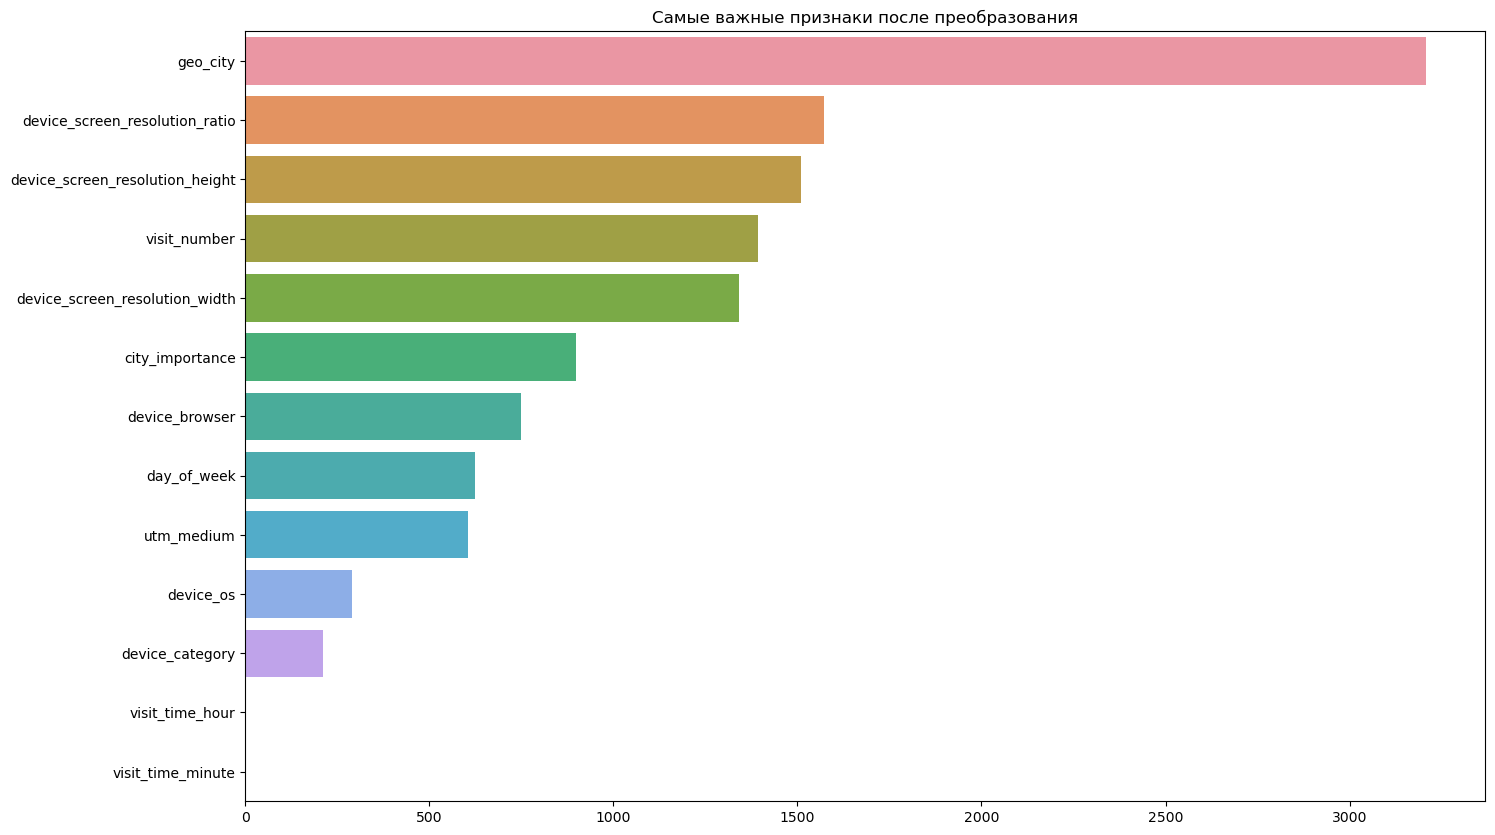

In [86]:
# Обучение модели LightGBM с выбранными гиперпараметрами
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)  # Обучение модели на тренировочных данных

# Получение важности признаков после обучения модели
importances = model.feature_importances_

# Создаем Series для удобства визуализации, связывая важности с именами признаков
import pandas as pd
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(16, 10))
most_important = feat_importances.sort_values(ascending=False)  # Сортируем по убыванию важности
sns.barplot(x=most_important, y=most_important.index, orient='h')  # Гистограмма по признакам
plt.title('Самые важные признаки после преобразования')  # Заголовок графика

### 7. Сохранение модели

In [88]:
import joblib

# Сохраняем модель в файл
joblib.dump(model, 'lgbm_model.pkl')

['lgbm_model.pkl']

In [11]:
import pickle

# пример: ваша модель называется clf
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Выводы

Для преобразования исходных данных в формат, пригодный для предсказаний, были выполнены следующие ключевые этапы:

* Заполнение пропусков и создание новых признаков.
* Нормализация числовых переменных.
* Преобразование категориальных признаков.

После предварительной обработки были протестированы три модели: LogisticRegression, LightGBM и CatBoost. Все они показали достойные результаты, однако для дальнейшей работы предпочтение было отдано LightGBM благодаря его высокой скорости обучения.

Оптимизация гиперпараметров модели не привела к значительным улучшениям, что указывает на необходимость более тщательного поиска оптимальных настроек.

Текущий показатель качества модели по метрике ROC-AUC составляет 0.687.

Для повышения точности предсказаний можно рассмотреть следующие направления:

* Увеличение объема данных и добавление новых признаков.
* Проведение ребалансировки классов.
* Более глубокий и систематический поиск оптимальных гиперпараметров.
* Эксперименты с более сложными моделями, например, нейронными сетями глубокого обучения.